In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import PIL

import numpy as np
import matplotlib.pyplot as plt

import os
import re
import copy

from tqdm.auto import tqdm

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
import matplotlib.image as mpimg

In [4]:
f_path = "data/flowers/trimaps/"

In [5]:
IMAGE_SIZE = 224

In [6]:
USE_CUDA = True

In [7]:
1360 / 80

17.0

In [8]:
class FlowerImages(Dataset):
    def __init__(self, folder_path,  transforms=None):
        self.data_root_folder = folder_path
        self.image_list  = self.load_image_list(self.data_root_folder)
        self.label_list = []
        self.transforms = transforms
        
        self.class_num_list = {}
        self.class2num = {}
        self.calulate_image_class()
        
    def calulate_image_class(self):
        for image_file in self.image_list:
            image_num = int(re.split(r"(_|\.)",image_file)[-3]) - 1
            self.label_list.append(image_num // 80)
            # print(image_file, image_num // 80)
            if not image_num // 80 in self.class_num_list:
                self.class_num_list[image_num // 80] = 0
            else:
                self.class_num_list[image_num // 80] += 1
        
        for i, key in enumerate(sorted(self.class_num_list)):
            self.class2num[key] = i
            
        
        return
        
        
    def load_image_list(self, folder_path):
        image_list = []
        for image_file in os.listdir(folder_path):
            if image_file.endswith(".png"):
                image_list.append(os.path.join(folder_path, image_file))
        
        return image_list
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        # Open image
        img2 = mpimg.imread(single_image_path)
        channel1 = img2[:,:,0]
        channel1[np.where(channel1 > 0)] = 1
        channel1[np.where(channel1 < 1)] = 0
        channel2 = img2[:,:,1]
        channel2[np.where(channel2 > 0)] = 1
        channel2[np.where(channel2 < 1)] = 0
        channel1[np.where(channel2 > 0)] = 0
           
        img_tensor = channel1
        if self.transforms is not None:
            img_tensor = self.transforms(img_tensor)
            img_tensor = transforms.ToTensor()(np.array(img_tensor))
            
        label = self.class2num[self.label_list[index]]
        return img_tensor, label
        

In [9]:
my_transforms = transforms.Compose([
    transforms.ToPILImage(mode="F"),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomAffine(degrees = 90, translate = (0.2,0.2), scale = (0.6,1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
fi = FlowerImages(f_path, transforms=my_transforms)

In [11]:
fi[200][1]

4

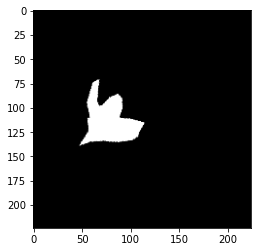

In [12]:
plt.imshow(fi[200][0][0],cmap="gray")

In [13]:
train_dataset_len = int(0.8 * len(fi))
test_dataset_len = len(fi) - train_dataset_len

In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(fi,[train_dataset_len, test_dataset_len])

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

In [16]:
model = EfficientNet.from_name('efficientnet-b0', in_channels = 1, num_classes = len(fi.class2num))

In [17]:
if torch.cuda.is_available() and USE_CUDA:
    model = model.cuda()

In [18]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
epoches = 100

In [25]:
for epoch in range(epoches):
    loss_epoch = []
    model.train()
    for batch_inputs, batch_scores in tqdm(train_dataloader):
        #print(batch_inputs.shape)
        #print(batch_scores.shape)
        if torch.cuda.is_available() and USE_CUDA:
                batch_inputs = batch_inputs.to("cuda")
                batch_scores = batch_scores.to("cuda")

        batch_pred = model(batch_inputs)

        loss = loss_fun(batch_pred, batch_scores)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss.item())

        # break

    model.eval()
    acc_epoch = []
    for batch_inputs, batch_scores in tqdm(test_dataloader):
        if torch.cuda.is_available() and USE_CUDA:
                batch_inputs = batch_inputs.to("cuda")
                batch_scores = batch_scores.to("cuda")

        batch_pred = model(batch_inputs)

        _, predictions = torch.max(batch_pred, dim=-1)

        acc = torch.mean(predictions.eq(batch_scores).float())

        acc_epoch.append(acc.item())

        # break

    avg_loss = np.mean(loss_epoch)
    avg_acc = np.mean(acc_epoch)
    print("epoch: {}, avg train loss {:.4f}, avg test acc {:.4f}".format(epoch, avg_loss, avg_acc))


epoch: 0, avg train loss 0.5390, avg test acc 0.6875



epoch: 1, avg train loss 0.5174, avg test acc 0.7227



epoch: 2, avg train loss 0.4728, avg test acc 0.6625



epoch: 3, avg train loss 0.5343, avg test acc 0.7318



epoch: 4, avg train loss 0.4694, avg test acc 0.6114



epoch: 5, avg train loss 0.5323, avg test acc 0.7807



epoch: 6, avg train loss 0.5064, avg test acc 0.7284



epoch: 7, avg train loss 0.5048, avg test acc 0.7148



epoch: 8, avg train loss 0.4899, avg test acc 0.6716



epoch: 9, avg train loss 0.5561, avg test acc 0.7148



epoch: 10, avg train loss 0.4501, avg test acc 0.7307



epoch: 11, avg train loss 0.4794, avg test acc 0.7216



epoch: 12, avg train loss 0.5382, avg test acc 0.7011



epoch: 13, avg train loss 0.5215, avg test acc 0.7114



epoch: 14, avg train loss 0.4778, avg test acc 0.6693



epoch: 15, avg train loss 0.4325, avg test acc 0.7148



epoch: 16, avg train loss 0.5143, avg test acc 0.7205



epoch: 17, avg train loss 0.4691, avg test acc 0.7045



epoch: 18, avg train loss 0.5565, avg test acc 0.6625



epoch: 19, avg train loss 0.4740, avg test acc 0.7023



epoch: 20, avg train loss 0.4547, avg test acc 0.6977



epoch: 21, avg train loss 0.4737, avg test acc 0.7102



epoch: 22, avg train loss 0.4999, avg test acc 0.7011



epoch: 23, avg train loss 0.4903, avg test acc 0.6716



epoch: 24, avg train loss 0.4607, avg test acc 0.7455



epoch: 25, avg train loss 0.4380, avg test acc 0.7466



epoch: 26, avg train loss 0.4763, avg test acc 0.6920



epoch: 27, avg train loss 0.4455, avg test acc 0.7727



epoch: 28, avg train loss 0.4593, avg test acc 0.7830



epoch: 29, avg train loss 0.4440, avg test acc 0.7580



epoch: 30, avg train loss 0.4821, avg test acc 0.7591



epoch: 31, avg train loss 0.4998, avg test acc 0.7477



epoch: 32, avg train loss 0.4285, avg test acc 0.6898



epoch: 33, avg train loss 0.4290, avg test acc 0.7261



epoch: 34, avg train loss 0.5373, avg test acc 0.7057



epoch: 35, avg train loss 0.4488, avg test acc 0.6739



epoch: 36, avg train loss 0.3970, avg test acc 0.6852



epoch: 37, avg train loss 0.4398, avg test acc 0.7000



epoch: 38, avg train loss 0.3864, avg test acc 0.7659



epoch: 39, avg train loss 0.4063, avg test acc 0.7682



epoch: 40, avg train loss 0.4311, avg test acc 0.6852



epoch: 41, avg train loss 0.4342, avg test acc 0.6795



epoch: 42, avg train loss 0.4136, avg test acc 0.6966



epoch: 43, avg train loss 0.3802, avg test acc 0.7420



epoch: 44, avg train loss 0.4279, avg test acc 0.7170



epoch: 45, avg train loss 0.4235, avg test acc 0.6773



epoch: 46, avg train loss 0.4180, avg test acc 0.6568



epoch: 47, avg train loss 0.3847, avg test acc 0.7148



epoch: 48, avg train loss 0.3679, avg test acc 0.7011



epoch: 49, avg train loss 0.3812, avg test acc 0.7409



epoch: 50, avg train loss 0.4707, avg test acc 0.6909



epoch: 51, avg train loss 0.4962, avg test acc 0.6716



epoch: 52, avg train loss 0.4660, avg test acc 0.6909



epoch: 53, avg train loss 0.3628, avg test acc 0.7261



epoch: 54, avg train loss 0.4076, avg test acc 0.7489



epoch: 55, avg train loss 0.3614, avg test acc 0.6795



epoch: 56, avg train loss 0.4174, avg test acc 0.7636



epoch: 57, avg train loss 0.3805, avg test acc 0.7045



epoch: 58, avg train loss 0.4503, avg test acc 0.7000



epoch: 59, avg train loss 0.4140, avg test acc 0.7295



epoch: 60, avg train loss 0.3749, avg test acc 0.6920



epoch: 61, avg train loss 0.4281, avg test acc 0.7807



epoch: 62, avg train loss 0.3414, avg test acc 0.7511



epoch: 63, avg train loss 0.4056, avg test acc 0.7136



epoch: 64, avg train loss 0.3862, avg test acc 0.6932



epoch: 65, avg train loss 0.3587, avg test acc 0.7432



epoch: 66, avg train loss 0.3795, avg test acc 0.6909



epoch: 67, avg train loss 0.4602, avg test acc 0.7602



epoch: 68, avg train loss 0.3438, avg test acc 0.8011



epoch: 69, avg train loss 0.3446, avg test acc 0.7545



epoch: 70, avg train loss 0.3821, avg test acc 0.7773



epoch: 71, avg train loss 0.4254, avg test acc 0.6920



epoch: 72, avg train loss 0.3946, avg test acc 0.7420



epoch: 73, avg train loss 0.3810, avg test acc 0.7034



epoch: 74, avg train loss 0.3753, avg test acc 0.6841



epoch: 75, avg train loss 0.3880, avg test acc 0.6864



epoch: 76, avg train loss 0.3739, avg test acc 0.6864



epoch: 77, avg train loss 0.3907, avg test acc 0.7636



epoch: 78, avg train loss 0.3454, avg test acc 0.6943



epoch: 79, avg train loss 0.3993, avg test acc 0.7773



epoch: 80, avg train loss 0.3325, avg test acc 0.7170



epoch: 81, avg train loss 0.3227, avg test acc 0.6682



epoch: 82, avg train loss 0.3320, avg test acc 0.6795



epoch: 83, avg train loss 0.3508, avg test acc 0.7420



epoch: 84, avg train loss 0.2972, avg test acc 0.7432



epoch: 85, avg train loss 0.3735, avg test acc 0.7614



epoch: 86, avg train loss 0.3636, avg test acc 0.7739



epoch: 87, avg train loss 0.3313, avg test acc 0.7170



epoch: 88, avg train loss 0.3395, avg test acc 0.7375



epoch: 89, avg train loss 0.3496, avg test acc 0.6898



epoch: 90, avg train loss 0.3111, avg test acc 0.7409



epoch: 91, avg train loss 0.3465, avg test acc 0.6909



epoch: 92, avg train loss 0.3654, avg test acc 0.7693



epoch: 93, avg train loss 0.3086, avg test acc 0.7636



epoch: 94, avg train loss 0.3643, avg test acc 0.7455



epoch: 95, avg train loss 0.3378, avg test acc 0.7693



epoch: 96, avg train loss 0.3507, avg test acc 0.7523



epoch: 97, avg train loss 0.3005, avg test acc 0.6591



epoch: 98, avg train loss 0.3167, avg test acc 0.7489



epoch: 99, avg train loss 0.3692, avg test acc 0.7341


In [21]:
# model

In [22]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [27]:
torch.save(model.state_dict(), "11_4_eff_flowers.pth")